In [7]:
%load_ext autoreload
%autoreload 2
import requests
import os
import pandas as pd
import dgl.function as fn
import matplotlib.pyplot as plt

import numpy as np

# from modules.gnn import GNN
import scipy.sparse as sp
import numpy as np
import os

from modules.graph import Graph
from utils import month_name_to_number, month_number_to_name

import torch
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Descargar archivo PeeringDB



## Información general

- `asn`: Número de Sistema Autónomo.
- `name`: Nombre corto de la red u organización.
- `name_long`: Nombre largo o completo de la organización.
- `aka`: Otros nombres por los que se conoce a la organización (alias).
- `org_id`: ID de la organización dentro de PeeringDB.
- `website`: Sitio web.
- `notes`: Notas adicionales públicas que la red haya dejado.



## Infraestructura de red

- `fac_count`: Número de datacenters (facilidades) donde opera.
- `ix_count`: Número de IXPs (puntos de intercambio de tráfico) en los que participa.
- `netfac_updated`: Fecha de última actualización de datos en facilidades.
- `netixlan_updated`: Fecha de última actualización de datos en IXPs.



## Políticas de peering

- `policy_general`: Política de peering. Valores típicos: `Open`, `Selective`, `Restrictive`, `No` (a veces vacío `''`).
- `policy_ratio`: Si el ratio de tráfico influye en la aceptación de peering (`True/False`).
- `policy_locations`: Dónde aplica la política. Ejemplos: `Required - US`, `Preferred`, `Required - EU`, `Required - International`, `Not Required` (a veces vacío `''`).
- `policy_contracts`: Si se requiere contrato. Ejemplos: `Private Only`, `Not Required`, `Required` (a veces vacío `''`).
- `policy_url`: URL pública donde se detalla la política de peering.



## Capacidad y tipo de tráfico

- `info_prefixes4`: Cantidad de prefijos IPv4 anunciados.
- `info_prefixes6`: Cantidad de prefijos IPv6 anunciados.
- `info_traffic`: Nivel estimado de tráfico (ej.: `100-200Gbps`, `20Gbps`, etc.).
- `info_unicast`: Soporta tráfico unicast (`True/False`).
- `info_multicast`: Soporta tráfico multicast (`True/False`).
- `info_ipv6`: Soporta tráfico IPv6 (`True/False`).
- `info_scope`: Alcance de la red (ej.: `Global`, `Regional`, `National`, etc.).
- `info_type`: Tipo de red (ej.: `NSP`, `Content`, `Enterprise`, etc.).
- `info_never_via_route_servers`: Indica si no acepta rutas vía route servers (`True/False`).
- `info_ratio`: Perfil de tráfico (ej.: `Balanced`, `Mostly Inbound`, `Mostly Outbound`, etc.; a veces vacío `''`).



## Monitoreo y herramientas

- `route_server`: (campo relacionado con route servers; puede venir vacío).
- `looking_glass`: URL del looking glass (para ver rutas anunciadas/recibidas).
- `status_dashboard`: Página de estado de la red (incidentes, mantenimientos, etc.).



## Tiempos y actualizaciones

- `created`: Fecha de creación del registro en PeeringDB.
- `updated`: Última fecha de actualización del registro general.
- `poc_updated`: Última vez que se actualizaron los contactos (Points of Contact).
- `id`: Identificador interno del registro.
- `allow_ixp_update`: Indica si los IXPs pueden actualizar la información de esta red.
- `irr_as_set`: Set de objetos IRR (Internet Routing Registry) usados para filtrado de rutas.


#### Funciones Auxiliares

In [ ]:
def dowload_peeringdb(year:str, month:str, day:str, output_dir:str='data/peeringdb/'):
    """
    Download the latest PeeringDB data from the official website.
    """

    # URL de descarga de PeeringDB data en caida
    url = f"https://publicdata.caida.org/datasets/peeringdb/{year}/{month}/peeringdb_2_dump_{year}_{month}_{day}.json"

    # Carpeta donde se guarda el archivo
    file_path = os.path.join(output_dir, f"peeringdb_{year}_{month_number_to_name(month)}_{day}.json")

    # Descargar el archivo
    try:
        response = requests.get(url)
    except:
        print(f"Error downloading PeeringDB data: {e}")
        return

    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"Downloaded PeeringDB data to {file_path}")
    return file_path

#### Descarga Archivo PeeringDB

In [ ]:
ANO = '2024'
MES = 'enero'
DIA = '01'

DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'
OUTPUT_DIR = DATA_PATH + 'peeringdb/'

peeringdb_file_path = dowload_peeringdb(ANO, month_name_to_number(MES), DIA, OUTPUT_DIR)

# 8 min

In [ ]:
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
DIA = '01'
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'
OUTPUT_DIR = DATA_PATH + 'peeringdb/'

for mes in meses:
    peeringdb_file_path = dowload_peeringdb(ANO, month_name_to_number(mes), DIA, OUTPUT_DIR)




In [36]:
import json

with open(peeringdb_file_path) as f:
    data = json.load(f)['net']['data']
    first_as = data[0]
    print("Llaves ASN:")
    for key in first_as.keys():
        print(f"  * {key}: {type(first_as[key])}")

Llaves ASN:
  * id: <class 'int'>
  * org_id: <class 'int'>
  * name: <class 'str'>
  * aka: <class 'str'>
  * name_long: <class 'str'>
  * website: <class 'str'>
  * social_media: <class 'list'>
  * asn: <class 'int'>
  * looking_glass: <class 'str'>
  * route_server: <class 'str'>
  * irr_as_set: <class 'str'>
  * info_type: <class 'str'>
  * info_types: <class 'list'>
  * info_prefixes4: <class 'int'>
  * info_prefixes6: <class 'int'>
  * info_traffic: <class 'str'>
  * info_ratio: <class 'str'>
  * info_scope: <class 'str'>
  * info_unicast: <class 'bool'>
  * info_multicast: <class 'bool'>
  * info_ipv6: <class 'bool'>
  * info_never_via_route_servers: <class 'bool'>
  * ix_count: <class 'int'>
  * fac_count: <class 'int'>
  * notes: <class 'str'>
  * netixlan_updated: <class 'str'>
  * netfac_updated: <class 'str'>
  * poc_updated: <class 'str'>
  * policy_url: <class 'str'>
  * policy_general: <class 'str'>
  * policy_locations: <class 'str'>
  * policy_ratio: <class 'bool'>
  *

#### Creación Diccionario 

Diccionario indica si el atributo es :
* Categorico: transforma en un one-hot vector
* Numerico: Normaliza y naja desviacion


In [37]:
# Listas con los nombres de los atributos que nos interesan
num_list = ['ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']

# Lista combinada de todos los atributos
list_all = num_list + categorical_list + boolean_list

# Inicializo un diccionario vacío
dict_attr = {}

# Recorrer cada atributo de la lista
for attr in list_all:
    # Asegurarse de que cada atributo tenga un diccionario inicializado
    if attr not in dict_attr:
        dict_attr[attr] = {}

    # Determinar si es numérico o no y agregarlo al diccionario
    if attr in num_list:
        dict_attr[attr]['categorical'] = False
    else:
        dict_attr[attr]['categorical'] = True

    # Set para los valores únicos
    uniques = set()
    count_empty = 0  # Inicializo el contador de valores vacíos

    # Iterar sobre los datos de 'data'
    for asn in data:
        value = asn.get(attr)  # Usar .get() para manejar posibles claves faltantes

        # Contar valores vacíos
        if value == '' or value is None:
            count_empty += 1

        # Agregar el valor al set de valores únicos
        uniques.add(value)

    # Guardar el número de valores únicos
    dict_attr[attr]['uniques'] = len(uniques)
    dict_attr[attr]['empty_count'] = count_empty  # Guardar el conteo de valores vacíos si es necesario

# Mostrar el diccionario resultante
for key, value in dict_attr.items():
    print(f"{key}: {value}")



ix_count: {'categorical': False, 'uniques': 84, 'empty_count': 0}
fac_count: {'categorical': False, 'uniques': 101, 'empty_count': 0}
info_prefixes4: {'categorical': False, 'uniques': 402, 'empty_count': 3100}
info_prefixes6: {'categorical': False, 'uniques': 257, 'empty_count': 3010}
policy_general: {'categorical': True, 'uniques': 5, 'empty_count': 2240}
policy_locations: {'categorical': True, 'uniques': 6, 'empty_count': 2240}
policy_contracts: {'categorical': True, 'uniques': 4, 'empty_count': 2334}
info_traffic: {'categorical': True, 'uniques': 19, 'empty_count': 13776}
info_scope: {'categorical': True, 'uniques': 11, 'empty_count': 453}
info_type: {'categorical': True, 'uniques': 11, 'empty_count': 9473}
info_ratio: {'categorical': True, 'uniques': 7, 'empty_count': 749}
policy_ratio: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_unicast: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_multicast: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_i

### Atributos Numericos



Atributos Númericos a ocupar:
* asn: Número de Sistema Autónomo
* ix_count: Cantidad ...
* fac_count: Cantidad ...
* info_prefixes4: Cantidad ...
* info_prefixes6: Cantidad ...

In [38]:
num_list = ['asn', 'ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']


# Crear DataFrame con los datos numéricos
num_data = {attr: [asn.get(attr, None) for asn in data] for attr in num_list}
num_df = pd.DataFrame(num_data)

# Logarithmic transformation to decrease their variability,
num_df[num_list[1:]] = num_df[num_list[1:]].astype(float)
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: np.log(x + 1))

# Normalization
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

num_df

,asn,ix_count,fac_count,info_prefixes4,info_prefixes6
0,4436,0.000000,0.000000,0.883505,0.746036
1,20940,0.930716,0.803274,0.679870,0.689900
2,31800,0.473768,0.000000,0.079520,0.000000
3,3303,0.713302,0.521619,0.666674,0.607176
4,22773,0.000000,0.403994,0.666674,0.648534
...,...,...,...,...,...
33006,214639,0.332509,0.000000,0.079520,0.732377
33007,272988,0.000000,0.000000,0.334054,0.318474
33008,274117,0.118442,0.000000,0.500072,0.648534
33009,402030,0.000000,0.000000,0.334054,0.559602


In [39]:

for colum in num_df.columns:
    min = num_df[colum].min()
    max = num_df[colum].max()
    print(f"Columna: {colum} Min: {min} Max: {max}") 

Columna: asn Min: 3 Max: 402030
Columna: ix_count Min: 0.0 Max: 1.0
Columna: fac_count Min: 0.0 Max: 1.0
Columna: info_prefixes4 Min: 0.0 Max: 1.0
Columna: info_prefixes6 Min: 0.0 Max: 1.0


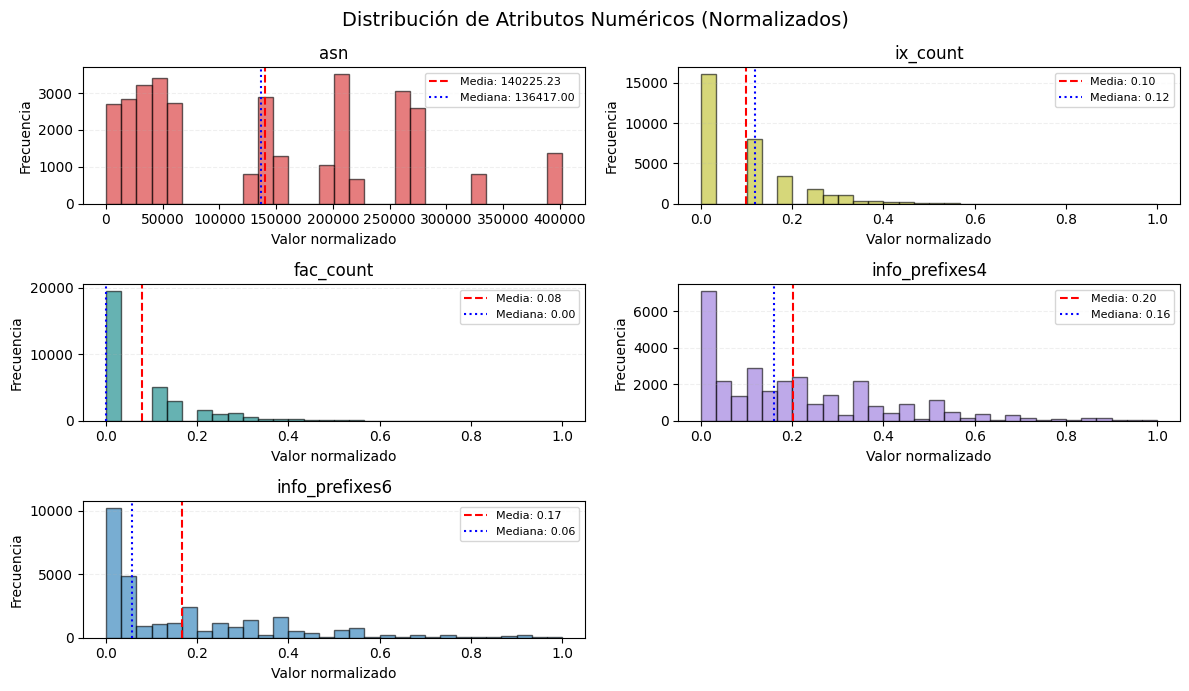

In [40]:
# Ahora graficamos usando subplots (estilo como la imagen)
cols = list(num_df.columns)
n = len(cols)

ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 7))
axs = np.array(axs).reshape(-1)  # flatten siempre

colors = ["tab:red", "tab:olive", "teal", "mediumpurple", "tab:blue", "tab:orange"]

for i, col in enumerate(cols):
    ax = axs[i]
    values = num_df[col].dropna().astype(float).values
    color = colors[i % len(colors)]

    ax.hist(values, bins=30, edgecolor="black", alpha=0.6, color=color)

    mean_val = float(np.mean(values)) if len(values) else float("nan")
    median_val = float(np.median(values)) if len(values) else float("nan")

    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Media: {mean_val:.2f}")
    ax.axvline(median_val, color="blue", linestyle=":", linewidth=1.5, label=f"Mediana: {median_val:.2f}")

    ax.set_title(col)
    ax.set_xlabel("Valor normalizado")
    ax.set_ylabel("Frecuencia")
    ax.grid(axis="y", alpha=0.2, linestyle="--")
    ax.legend(loc="upper right", fontsize=8)

# Ocultar ejes sobrantes (si n no llena la grilla)
for j in range(n, len(axs)):
    axs[j].axis("off")

fig.suptitle("Distribución de Atributos Numéricos (Normalizados)", fontsize=14)
plt.tight_layout()
plt.show()

## Atributos Categoricos

In [41]:
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']


# Listas de atributos
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']
list_all = num_list + categorical_list + boolean_list


# Crear DataFrame con los datos categóricos y hacer one-hot encoding
cat_data = {attr: [asn.get(attr, None) for asn in data] for attr in categorical_list}
cat_df = pd.DataFrame(cat_data)

# Realizar One-Hot Encoding para los atributos categóricos
cat_df_encoded = pd.get_dummies(cat_df, columns=categorical_list, prefix=categorical_list,dtype=int)
cat_df_encoded


,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,policy_locations_,policy_locations_Not Required,policy_locations_Preferred,policy_locations_Required - EU,policy_locations_Required - International,...,info_type_Non-Profit,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33006,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33007,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
33008,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33009,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
for attr in categorical_list:
    unique_vals = cat_df[attr].unique()
    print(f"Atributo: {attr}")
    print(f"Categorías únicas ({len(unique_vals)}): {unique_vals}\n")


Atributo: policy_general
Categorías únicas (5): ['Restrictive' 'Open' 'Selective' 'No' '']

Atributo: policy_locations
Categorías únicas (6): ['Required - International' 'Not Required' 'Preferred' 'Required - US' ''
 'Required - EU']

Atributo: policy_contracts
Categorías únicas (4): ['Required' 'Not Required' 'Private Only' '']

Atributo: info_traffic
Categorías únicas (19): ['' '100+Tbps' '100-1000Mbps' '1-5Tbps' '100-200Gbps' '10-20Gbps'
 '500-1000Gbps' '20-50Gbps' '0-20Mbps' '20-50Tbps' '1-5Gbps' '10-20Tbps'
 '20-100Mbps' '50-100Gbps' '5-10Tbps' '300-500Gbps' '200-300Gbps'
 '5-10Gbps' '50-100Tbps']

Atributo: info_scope
Categorías únicas (11): ['Global' 'Europe' 'North America' 'Regional' 'Asia Pacific'
 'South America' '' 'Not Disclosed' 'Australia' 'Africa' 'Middle East']

Atributo: info_type
Categorías únicas (11): ['NSP' 'Content' 'Non-Profit' 'Cable/DSL/ISP' '' 'Educational/Research'
 'Network Services' 'Route Server' 'Route Collector' 'Enterprise'
 'Government']

Atributo: in

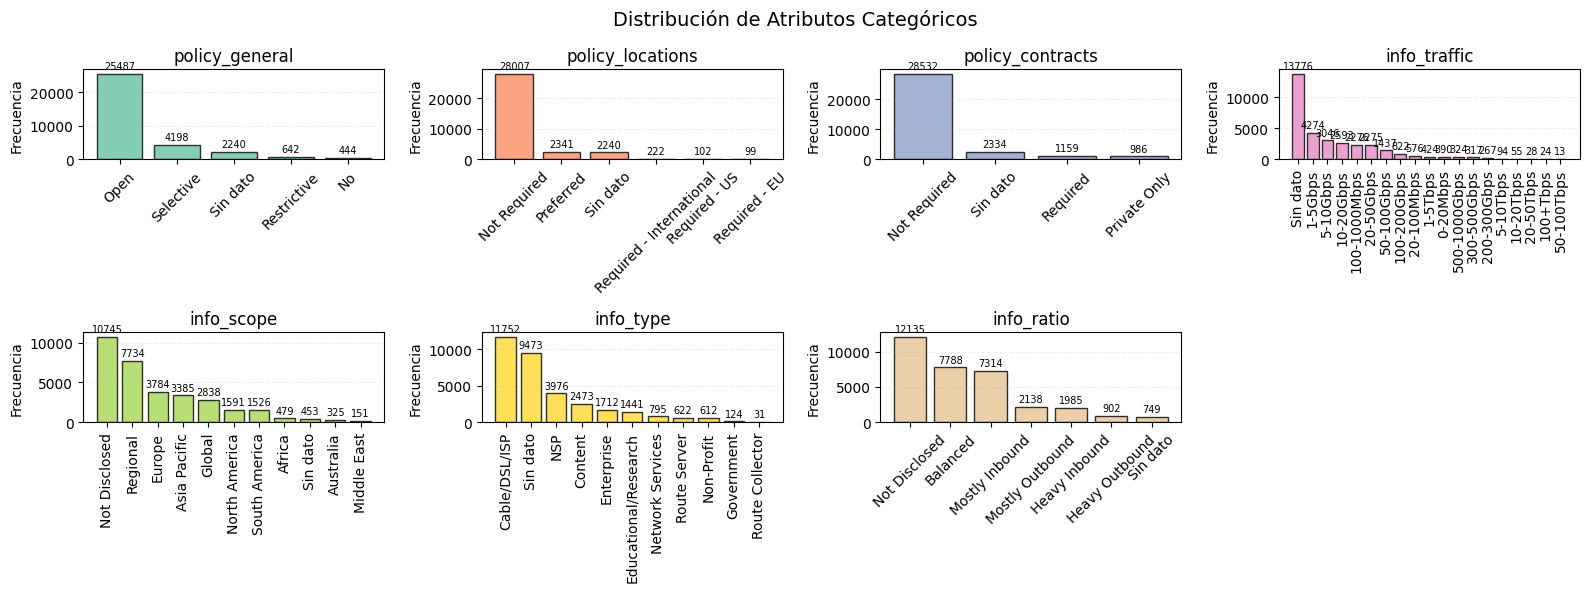

In [43]:
# Ahora graficamos los atributos categóricos (estilo como la imagen)
attrs = list(categorical_list)
n = len(attrs)

ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6))
axs = np.array(axs).reshape(-1)  # flatten

colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

def _clean_category(x):
    if x is None or (isinstance(x, float) and np.isnan(x)) or x == "":
        return "Sin dato"
    return str(x)

for i, attr in enumerate(attrs):
    ax = axs[i]
    series = cat_df[attr].map(_clean_category)
    value_counts = series.value_counts(dropna=False)
    color = colors[i % len(colors)]

    bars = ax.bar(value_counts.index.astype(str), value_counts.values, edgecolor="black", alpha=0.8, color=color)
    ax.set_title(attr)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")
    ax.grid(axis="y", alpha=0.2, linestyle="--")

    # Rotación dinámica según cantidad de categorías
    rotation = 90 if len(value_counts) > 8 else 45
    ax.tick_params(axis="x", rotation=rotation)

    # Etiquetas con el conteo arriba de cada barra
    ax.bar_label(bars, labels=[str(v) for v in value_counts.values], padding=2, fontsize=7, rotation=0)

# Ocultar ejes sobrantes
for j in range(n, len(axs)):
    axs[j].axis("off")

fig.suptitle("Distribución de Atributos Categóricos", fontsize=14)
plt.tight_layout()
plt.show()

## Juntar DataFrames: Atributos Numéricos + Atributos Categóricos 


In [44]:


# Concatenar todos los DataFrames (numéricos, categóricos y booleanos)
final_df = pd.concat([num_df, cat_df_encoded], axis=1)

final_df.sort_values(by='asn')



,asn,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Non-Profit,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
3297,3,0.000000,0.163894,0.173565,0.056144,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7697,4,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
10245,6,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
16092,7,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9091,8,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25064,401936,0.118442,0.103406,0.079520,0.194227,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
25201,402003,0.000000,0.000000,NaN,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
25198,402005,0.000000,0.000000,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
25237,402026,0.000000,0.000000,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:



final_df[final_df.select_dtypes('bool').columns] = final_df.select_dtypes('bool').astype(int)
final_df = final_df.rename(columns={'asn': 'ASN'})


final_df = final_df.sort_values(by='ASN', ascending=True)



In [ ]:
print(final_df.shape)
final_df.tail(2)

(33011, 68)


,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Non-Profit,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
25237,402026,0.0,0.0,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33009,402030,0.0,0.0,0.334054,0.559602,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Contar el número de columnas
num_columns = final_df.shape[1]

# Mostrar el número de columnas
print(f'Número de columnas: {num_columns}')

Número de columnas: 68


In [ ]:
# Guardar el DataFrame final en un archivo CSV
final_df.to_csv(f'{DATA_PATH}node_features_{MES}_{ANO}_{DIA}.csv', index=False)

## agregar attr page Rank

In [ ]:


# # Creacion grafo:

# import torch
# import dgl
# from modules.gnn import GNN


# # Definimos las rutas de los archivos
# base_path = os.getcwd() + "/data/"
# relationships_file = base_path + f"CAIDA_AS_Relationships/Serial_1/{ANO}{month_name_to_number(MES)}{DIA}.as-rel.txt.bz2"
# features_file = base_path + "/node_features.csv"
# rib_path = base_path + 'sanitized_rib.txt'
# dataset_graph_path = base_path + 'dgl_graph/'



NameError: name 'year' is not defined

In [ ]:
# gnn = GNN(debug=True)
# gnn.load_dataset(dataset_graph_path, force_reload=True)

# print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)

Done saving data into cached files.
Graph(num_nodes=43183, num_edges=133091,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([43183, 68])


In [ ]:


# # ----------- Run PageRank for Graph -------------- #
# N = gnn.dgl_graph.number_of_nodes()

# DAMP = 0.85
# K = 10

# def compute_pagerank(g):
#     g.ndata["pv"] = torch.ones(N) / N
#     degrees = g.out_degrees(g.nodes()).type(torch.float32)
#     for k in range(K):
#         g.ndata["pv"] = g.ndata["pv"] / degrees
#         g.update_all(
#             message_func=fn.copy_u(u="pv", out="m"),
#             reduce_func=fn.sum(msg="m", out="pv"),
#         )
#         g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
#     g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
#     return g.ndata["pv"]


# pv = compute_pagerank(gnn.dgl_graph)
# gnn.dgl_graph.ndata["h"] = pv  # Inicializa características del nodo

# print(gnn.dgl_graph.ndata["h"])



tensor([[2.2628e-05],
        [1.6470e-05],
        [2.4232e-05],
        ...,
        [3.4736e-06],
        [3.6272e-06],
        [3.4736e-06]])


In [ ]:


# # Obtenemos serie de ASN del df

# pr_values = []
# for asn in final_df['ASN']:
#     try:
#         pr_values.append(gnn.dgl_graph.ndata['h'][asn].item()) 
#     except:
#         pr_values.append(0) # FIXME: Revissar

# len(pr_values)



25273

In [ ]:
# # Normlaizamos los valores de PageRank
# pr_values = np.array(pr_values)  

# pr_min = pr_values.min()
# pr_max = pr_values.max()

# pagerank_norm = (pr_values - pr_min) / (pr_max - pr_min)

# final_df['PageRank'] = pr_values

In [ ]:
# final_df

,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed,PageRank
4143,3,0.0000,0.165327,0.173565,0.058158,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.000023
10001,4,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000012
13817,6,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000003
22611,7,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000013
12032,8,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24817,400705,0.0000,0.000000,0.079520,0.201193,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0.000000
24889,400721,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000000
25029,400735,0.1224,0.104310,0.116495,0.058158,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.000000
23248,401307,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000000


In [ ]:
final_df.to_csv('data/node_features_mio.csv', index=False)

In [ ]:
final_df['PageRank'].max()

6.763896089978516e-05

In [ ]:
final_df['PageRank'].max()
final_df['PageRank'].min()

0.0